In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from pathlib import Path
import os.path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 94% 988M/1.03G [00:03<00:00, 239MB/s]
100% 1.03G/1.03G [00:03<00:00, 278MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Archive:  asl-alphabet.zip
replace asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import pandas as pd

def imgPaths(filepath):
  labels = [str(filepath[i]).split("/")[-2] \
  for i in range(len(filepath))]
  filepath = pd.Series(filepath, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  df = pd.concat([filepath, labels], axis=1)

  df = df.sample(frac=1).reset_index(drop = True)
  return df

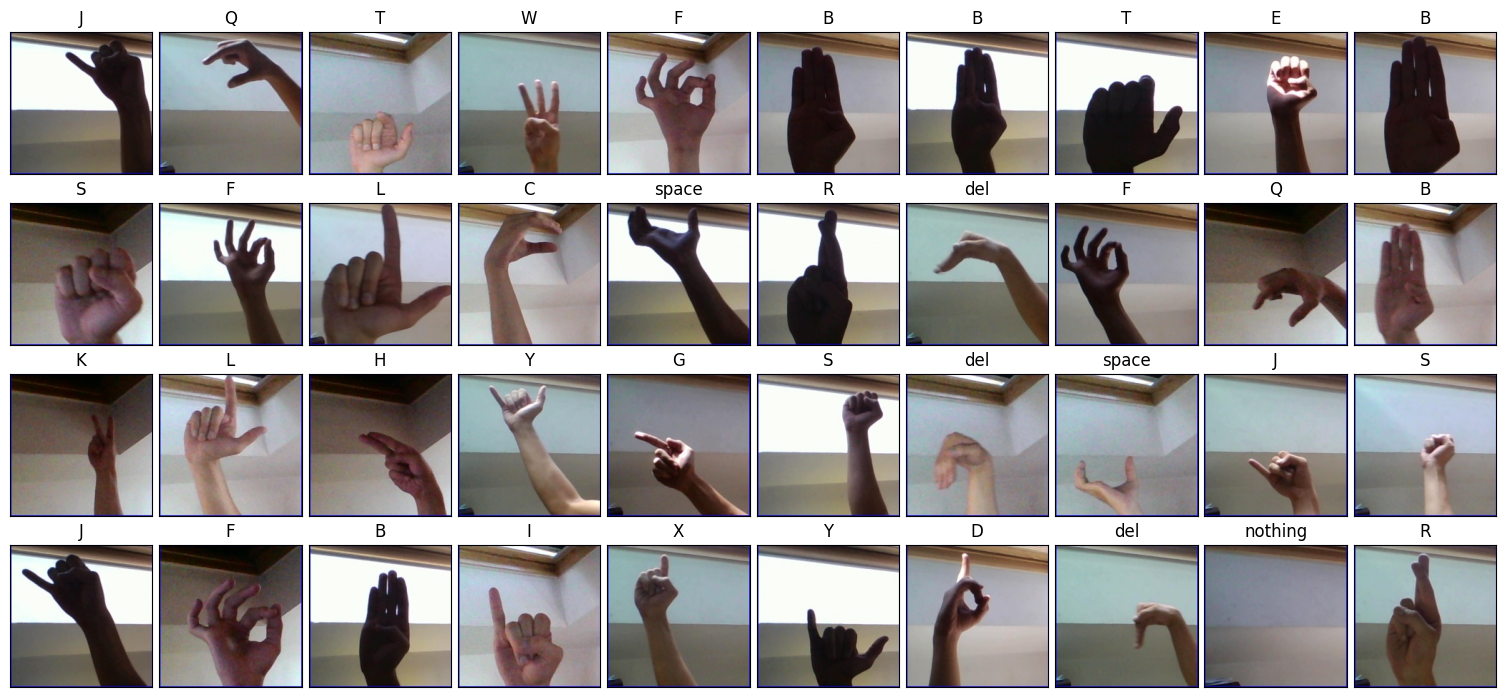

In [6]:
import matplotlib.pyplot as plt

image_path_dir = Path('/content/asl_alphabet_train')
image_path_list = list(image_path_dir.glob(r'**/*.jpg'))
images = imgPaths(image_path_list)

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(images.Filepath[i]))
  ax.set_title(images.Label[i])
plt.tight_layout(pad=.5)
plt.show()

In [7]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [8]:
source_dir = '/content/asl_alphabet_train/asl_alphabet_train'

In [9]:
base_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [10]:
full_dataset = datasets.ImageFolder(root=source_dir, transform=base_transform, target_transform=None)

In [11]:
import random

def get_mean_and_std_2(dataset, sample_size=5000):
    indices = random.sample(range(len(dataset)), sample_size)
    subset = torch.utils.data.Subset(dataset, indices)
    loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=False, num_workers=4)

    mean = 0.
    std = 0.
    total = 0

    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += images.size(0)

    mean /= total
    std /= total

    return mean, std

In [12]:
# mniej wydajna wersja

def get_mean_and_std(loader):
  mean = 0.
  std = 0.
  total_images_count = 0

  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch

  mean /= total_images_count
  std /= total_images_count

  return mean, std

In [13]:
from torch.utils.data import DataLoader
loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

mean_1, std_1 = get_mean_and_std(loader)
mean_1, std_1

(tensor([0.5187, 0.4988, 0.5147]), tensor([0.2017, 0.2310, 0.2390]))

In [14]:
"""
from torch.utils.data import DataLoader
loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

mean_2, std_2 = get_mean_and_std_2(full_dataset)
mean_2, std_2
"""

'\nfrom torch.utils.data import DataLoader\nloader = DataLoader(full_dataset, batch_size=64, shuffle=False)\n\nmean_2, std_2 = get_mean_and_std_2(full_dataset)\nmean_2, std_2\n'

In [15]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_1), torch.Tensor(std_1))
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean_1), torch.Tensor(std_1)) #normalizujemy piksele z zakresu od [0,255] do [0.0, 1.0]
])

In [16]:
train_dataset = datasets.ImageFolder(root=source_dir, transform=train_transform, target_transform=None)
test_dataset = datasets.ImageFolder(root=source_dir, transform=test_transform, target_transform=None)

In [17]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [18]:
import numpy as np

def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('labels: ', labels)

labels:  tensor([ 9,  6, 10,  2, 10, 18])


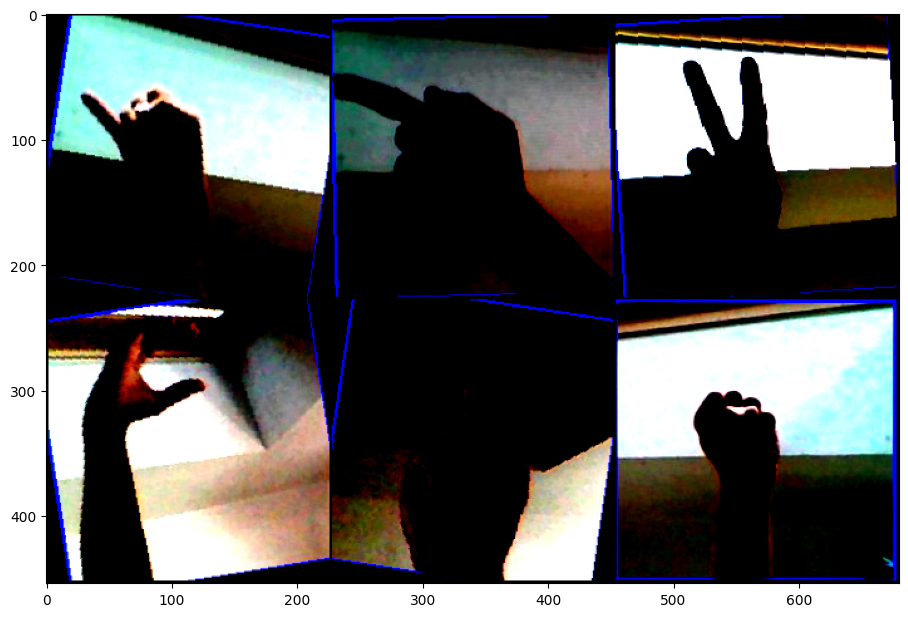

In [19]:
show_transformed_images(train_dataset)

In [20]:
from torch.utils.data import random_split, Subset
from collections import defaultdict


train_size = int(len(full_dataset) * 0.8)
test_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)
indices = torch.randperm(len(full_dataset), generator=generator).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)



def count_labels(subset):
    label_counts = defaultdict(int)
    for i in subset.indices:
        label = full_dataset[i][1]
        label_counts[label] += 1
    return dict(label_counts)

print(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")
print("Train label distribution:", count_labels(train_dataset))
print("Test label distribution:", count_labels(test_dataset))

Train size: 69600 | Test size: 17400
Train label distribution: {2: 2416, 21: 2399, 11: 2396, 0: 2400, 9: 2393, 16: 2392, 7: 2408, 27: 2426, 26: 2411, 3: 2425, 24: 2397, 22: 2427, 5: 2383, 28: 2407, 10: 2450, 20: 2395, 12: 2397, 19: 2407, 13: 2416, 8: 2423, 6: 2374, 15: 2387, 14: 2382, 1: 2424, 25: 2385, 18: 2357, 17: 2404, 23: 2364, 4: 2355}
Test label distribution: {22: 573, 16: 608, 2: 584, 12: 603, 8: 577, 13: 584, 5: 617, 20: 605, 25: 615, 10: 550, 6: 626, 28: 593, 0: 600, 11: 604, 21: 601, 3: 575, 19: 593, 15: 613, 9: 607, 23: 636, 7: 592, 14: 618, 1: 576, 24: 603, 27: 574, 26: 589, 17: 596, 4: 645, 18: 643}


In [21]:
"""
from torch.utils.data import random_split, Subset
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Z zachowaniem proporcji klas

labels = [full_dataset[i][1] for i in range(len(full_dataset))]

train_indices, test_indices = train_test_split(
    list(range(len(full_dataset))),
    stratify=labels,
    test_size=0.2,
    random_state=42,
)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

def count_labels(subset):
    label_counts = defaultdict(int)
    for i in subset.indices:
        label = full_dataset[i][1]
        label_counts[label] += 1
    return dict(label_counts)

print(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")
print("Train label distribution:", count_labels(train_dataset))
print("Test label distribution:", count_labels(test_dataset))
"""

'\nfrom torch.utils.data import random_split, Subset\nfrom sklearn.model_selection import train_test_split\nfrom collections import defaultdict\n\n# Z zachowaniem proporcji klas\n\nlabels = [full_dataset[i][1] for i in range(len(full_dataset))]\n\ntrain_indices, test_indices = train_test_split(\n    list(range(len(full_dataset))),\n    stratify=labels,\n    test_size=0.2,\n    random_state=42,\n)\n\ntrain_dataset = Subset(full_dataset, train_indices)\ntest_dataset = Subset(full_dataset, test_indices)\n\ndef count_labels(subset):\n    label_counts = defaultdict(int)\n    for i in subset.indices:\n        label = full_dataset[i][1]\n        label_counts[label] += 1\n    return dict(label_counts)\n\nprint(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")\nprint("Train label distribution:", count_labels(train_dataset))\nprint("Test label distribution:", count_labels(test_dataset))\n'

In [22]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=1, shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=1, shuffle=False)

len(train_dataloader), len(test_dataloader)

(2175, 544)

In [23]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [29]:
import copy

def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, early_stopping_patience=3):
  device = set_device()

  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

  best_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())
  epochs_no_improve = 0

  for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      running_correct += (labels == predicted).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / total

    test_loss, test_acc = evaluate_model(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc*100:.2f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth") #zapisanie modelu z konkretnej epoki

    #sprawdzenie czy najlepszy wynik
    if test_acc > best_acc:
        print(f"New best model found at epoch {epoch+1}!")
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    #early stopping
    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    #przywrocenie najlepszych wag modelu
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model_weights.pth")
    torch.save(model, "best_model_full.pth")

  return model, results

In [25]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  device = set_device()

  with torch.inference_mode():  #ewentualnie .no_grad()
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)

      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  avg_loss = test_loss / len(test_loader)
  accuracy = correct / total
  return avg_loss, accuracy

In [26]:
!pip install efficientnet_pytorch torchinfo

In [27]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary
from torch import nn

num_classes = len(full_dataset.classes)
device = set_device()

model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
num_features = model._fc.in_features

model._fc = nn.Linear(num_features, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Loaded pretrained weights for efficientnet-b0


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 29]              --                   True
├─Conv2dStaticSamePadding (_conv_stem)                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    └─ZeroPad2d (static_padding)                            [1, 3, 224, 224]     [1, 3, 225, 225]     --                   --
├─BatchNorm2d (_bn0)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
├─MemoryEfficientSwish (_swish)                              [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   True
│    └─MBConvBlock (0)                                       [1, 32, 112, 112]    [1, 16, 112, 1

Dodać timer:
from timeit import default_timer as timer
start_time = timer()

funkcja train

end_time = timer()

In [30]:
from timeit import default_timer as timer
start_time = timer()

trained_model, model_results = train_nn(model, train_dataloader, test_dataloader, loss_fn, optimizer, 7, 2)

end_time = timer()

training_time = end_time - start_time
print(training_time)


Epoch 1/7
Train Loss: 0.0918, Train Acc: 97.50%
Test  Loss: 0.0154, Test  Acc: 99.54%
New best model found at epoch 1!

Epoch 2/7
Train Loss: 0.0260, Train Acc: 99.24%
Test  Loss: 0.0234, Test  Acc: 99.42%
No improvement for 1 epoch(s).

Epoch 3/7
Train Loss: 0.0315, Train Acc: 99.09%
Test  Loss: 0.0089, Test  Acc: 99.74%
New best model found at epoch 3!

Epoch 4/7
Train Loss: 0.0194, Train Acc: 99.44%
Test  Loss: 0.0185, Test  Acc: 99.43%
No improvement for 1 epoch(s).

Epoch 5/7
Train Loss: 0.0197, Train Acc: 99.44%
Test  Loss: 0.0038, Test  Acc: 99.88%
New best model found at epoch 5!

Epoch 6/7
Train Loss: 0.0154, Train Acc: 99.59%
Test  Loss: 0.0087, Test  Acc: 99.83%
No improvement for 1 epoch(s).

Epoch 7/7
Train Loss: 0.0169, Train Acc: 99.53%
Test  Loss: 0.0003, Test  Acc: 99.99%
New best model found at epoch 7!
3727.185276231


In [31]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    # results dictionary
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

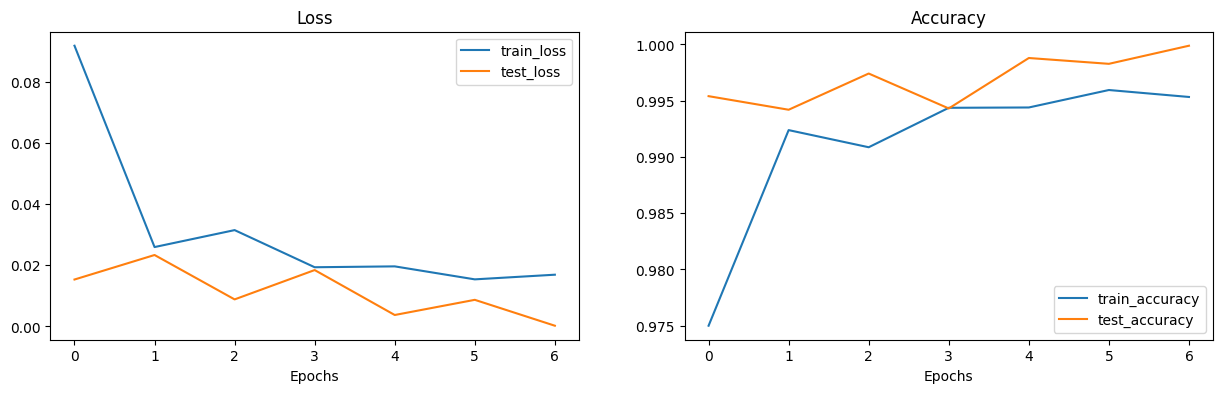

In [32]:
plot_loss_curves(model_results)

In [33]:
#torch.save(trained_model.state_dict(), "efficientnet_asl.pth")

In [34]:
#torch.save(trained_model, "efficientnet_asl_full.pth")

In [35]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes)
model.load_state_dict(torch.load("best_model_weights.pth"))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    